In [1]:
import pandas as pd
import seaborn as sb
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage

import itertools
from itertools import combinations

from io import BytesIO
import requests

In [2]:
spreadsheet_id = '1VenWiFZQXWtDs5S6ScOxFyAcBsETBxeV7ItD3eefNDM'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

In [3]:
df.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


We see no duplicates in our dataset, however there are missing values in "Balance".

In [6]:
df.columns = ['user_id', 'credit_score', 'city', 'gender', 'age', 'objects', 
              'balance', 'products', 'credit_card', 'loyalty', 'salary', 'churn']
df.head(0)

,user_id,credit_score,city,gender,age,objects,balance,products,credit_card,loyalty,salary,churn


For better examination of our dataset, lets distribute Salary, Age and Credit Score in quantiles.

In [7]:
salary_quantiles = df.describe()['salary']['25%':'max'].round(2)

def salary_quantizer(df):

    q25 = salary_quantiles[0]
    q50 = salary_quantiles[1]
    q75 = salary_quantiles[2]
    q100 = salary_quantiles[3]
    
    salary = df['salary']
    
    if salary <= q25:
        return q25
    
    if salary > q25 and salary <= q50:
        return q50
    
    if salary > q50 and salary <= q75:
        return q75
    
    if salary > q75 and salary <= q100:
        return q100
    
df['salary_quantiles'] = df.apply(salary_quantizer, axis=1)

In [8]:
age_quantiles = df.describe().round(2)['age']['25%':'max'].round(2)

def ager(df):

    q25 = age_quantiles[0]
    q50 = age_quantiles[1]
    q75 = age_quantiles[2]
    q100 = age_quantiles[3]
    
    age = df['age']
    
    if age <= q25:
        return q25
    
    if age > q25 and age <= q50:
        return q50
    
    if age > q50 and age <= q75:
        return q75
    
    if age > q75 and age <= q100:
        return q100
    
df['age_quantiles'] = df.apply(ager, axis=1)

In [9]:
cred_score_quantiles = df.describe().round(2)['credit_score']['25%':'max'].round(2)

def cred_scorer(df):

    q25 = cred_score_quantiles[0]
    q50 = cred_score_quantiles[1]
    q75 = cred_score_quantiles[2]
    q100 = cred_score_quantiles[3]
    
    score = df['credit_score']
    
    if score <= q25:
        return q25
    
    if score > q25 and score <= q50:
        return q50
    
    if score > q50 and score <= q75:
        return q75
    
    if score > q75 and score <= q100:
        return q100
    
df['cred_score_quantiles'] = df.apply(cred_scorer, axis=1)

In [10]:
df.head(5)

,user_id,credit_score,city,gender,age,objects,balance,products,credit_card,loyalty,salary,churn,salary_quantiles,age_quantiles,cred_score_quantiles
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,149388.25,44.0,652.0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,149388.25,44.0,652.0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,149388.25,44.0,584.0
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,100193.92,44.0,718.0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,100193.92,44.0,850.0


In [11]:
zero_balance = df[df['balance'].isnull() == True]

for i in df.head(0).drop(['user_id', 'balance', 'salary', 'credit_score', 'age'], axis=1):
    table = zero_balance.pivot_table(index=i, values='user_id', aggfunc='count').round(2)
    table.columns = ['zero_balance_users']
    display(table)

,zero_balance_users
city,
Рыбинск,1199
Ярославль,2418


,zero_balance_users
gender,
Ж,1654
М,1963


,zero_balance_users
objects,
0,137
1,349
2,382
3,352
4,369
5,374
6,367
7,386
8,363


,zero_balance_users
products,
1,905
2,2600
3,98
4,14


,zero_balance_users
credit_card,
0,1025
1,2592


,zero_balance_users
loyalty,
0,1744
1,1873


,zero_balance_users
churn,
0,3117
1,500


,zero_balance_users
salary_quantiles,
51002.11,927
100193.92,913
149388.25,886
199992.48,891


,zero_balance_users
age_quantiles,
32.0,1070
37.0,856
44.0,924
92.0,767


,zero_balance_users
cred_score_quantiles,
584.0,932
652.0,902
718.0,906
850.0,877


Here we see 4 major signs:

1. Clients from Yaroslavl (Ярославль) have 1.5 times more lost data than clients from Rybinsk (Рыбинск), and clients from Rostov Veliky (Ростов Великий) don't have empty data at all.

2. Clients with only 2 products have more loss in data then clients with 3 or 4 products.

3. Clients wihth credit card have 1.5 more data loss than clients without one.

4. Clients that stayed have 6 times more data loss then clients that left (this can be explained that latter are not registered in the system anymore)

Before we do clasterization we need to make correlation matrix

In [12]:
df.drop('user_id', axis=1, inplace=True)

In [13]:
df['gender'].replace(['Ж', 'М'], [0, 1], inplace=True)

In [14]:
df['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [15]:
df['city'].replace(list(df['city'].unique()),list(range(0, len(df['city'].unique()))), inplace=True)

In [16]:
df = df.drop(['salary_quantiles', 'age_quantiles', 'cred_score_quantiles'], axis=1)

In [17]:
df.describe().drop('count', axis=0).round(2)

,credit_score,city,gender,age,objects,balance,products,credit_card,loyalty,salary,churn
mean,650.53,0.75,0.55,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.2
std,96.65,0.83,0.50,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.4
min,350.00,0.00,0.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0
25%,584.00,0.00,0.00,32.00,3.00,100181.98,1.00,0.00,0.00,51002.11,0.0
50%,652.00,0.00,1.00,37.00,5.00,119839.69,1.00,1.00,1.00,100193.92,0.0
75%,718.00,2.00,1.00,44.00,7.00,139512.29,2.00,1.00,1.00,149388.25,0.0
max,850.00,2.00,1.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


Here we can see that majority of clients are male with 1 or 2 bank products

In [18]:
df.groupby(['products']).mean().round(2)

,credit_score,city,gender,age,objects,balance,credit_card,loyalty,salary,churn
products,,,,,,,,,,
1,649.12,0.77,0.55,39.67,4.97,119894.16,0.70,0.50,99487.26,0.28
2,652.19,0.71,0.55,37.75,5.05,119660.94,0.71,0.53,100452.01,0.08
3,648.11,0.97,0.44,43.20,5.00,119475.69,0.71,0.42,104318.13,0.83
4,653.58,0.92,0.37,45.68,5.30,122260.61,0.68,0.48,104763.72,1.00


Examined table above we can see that cleints with most products are female at age of 45

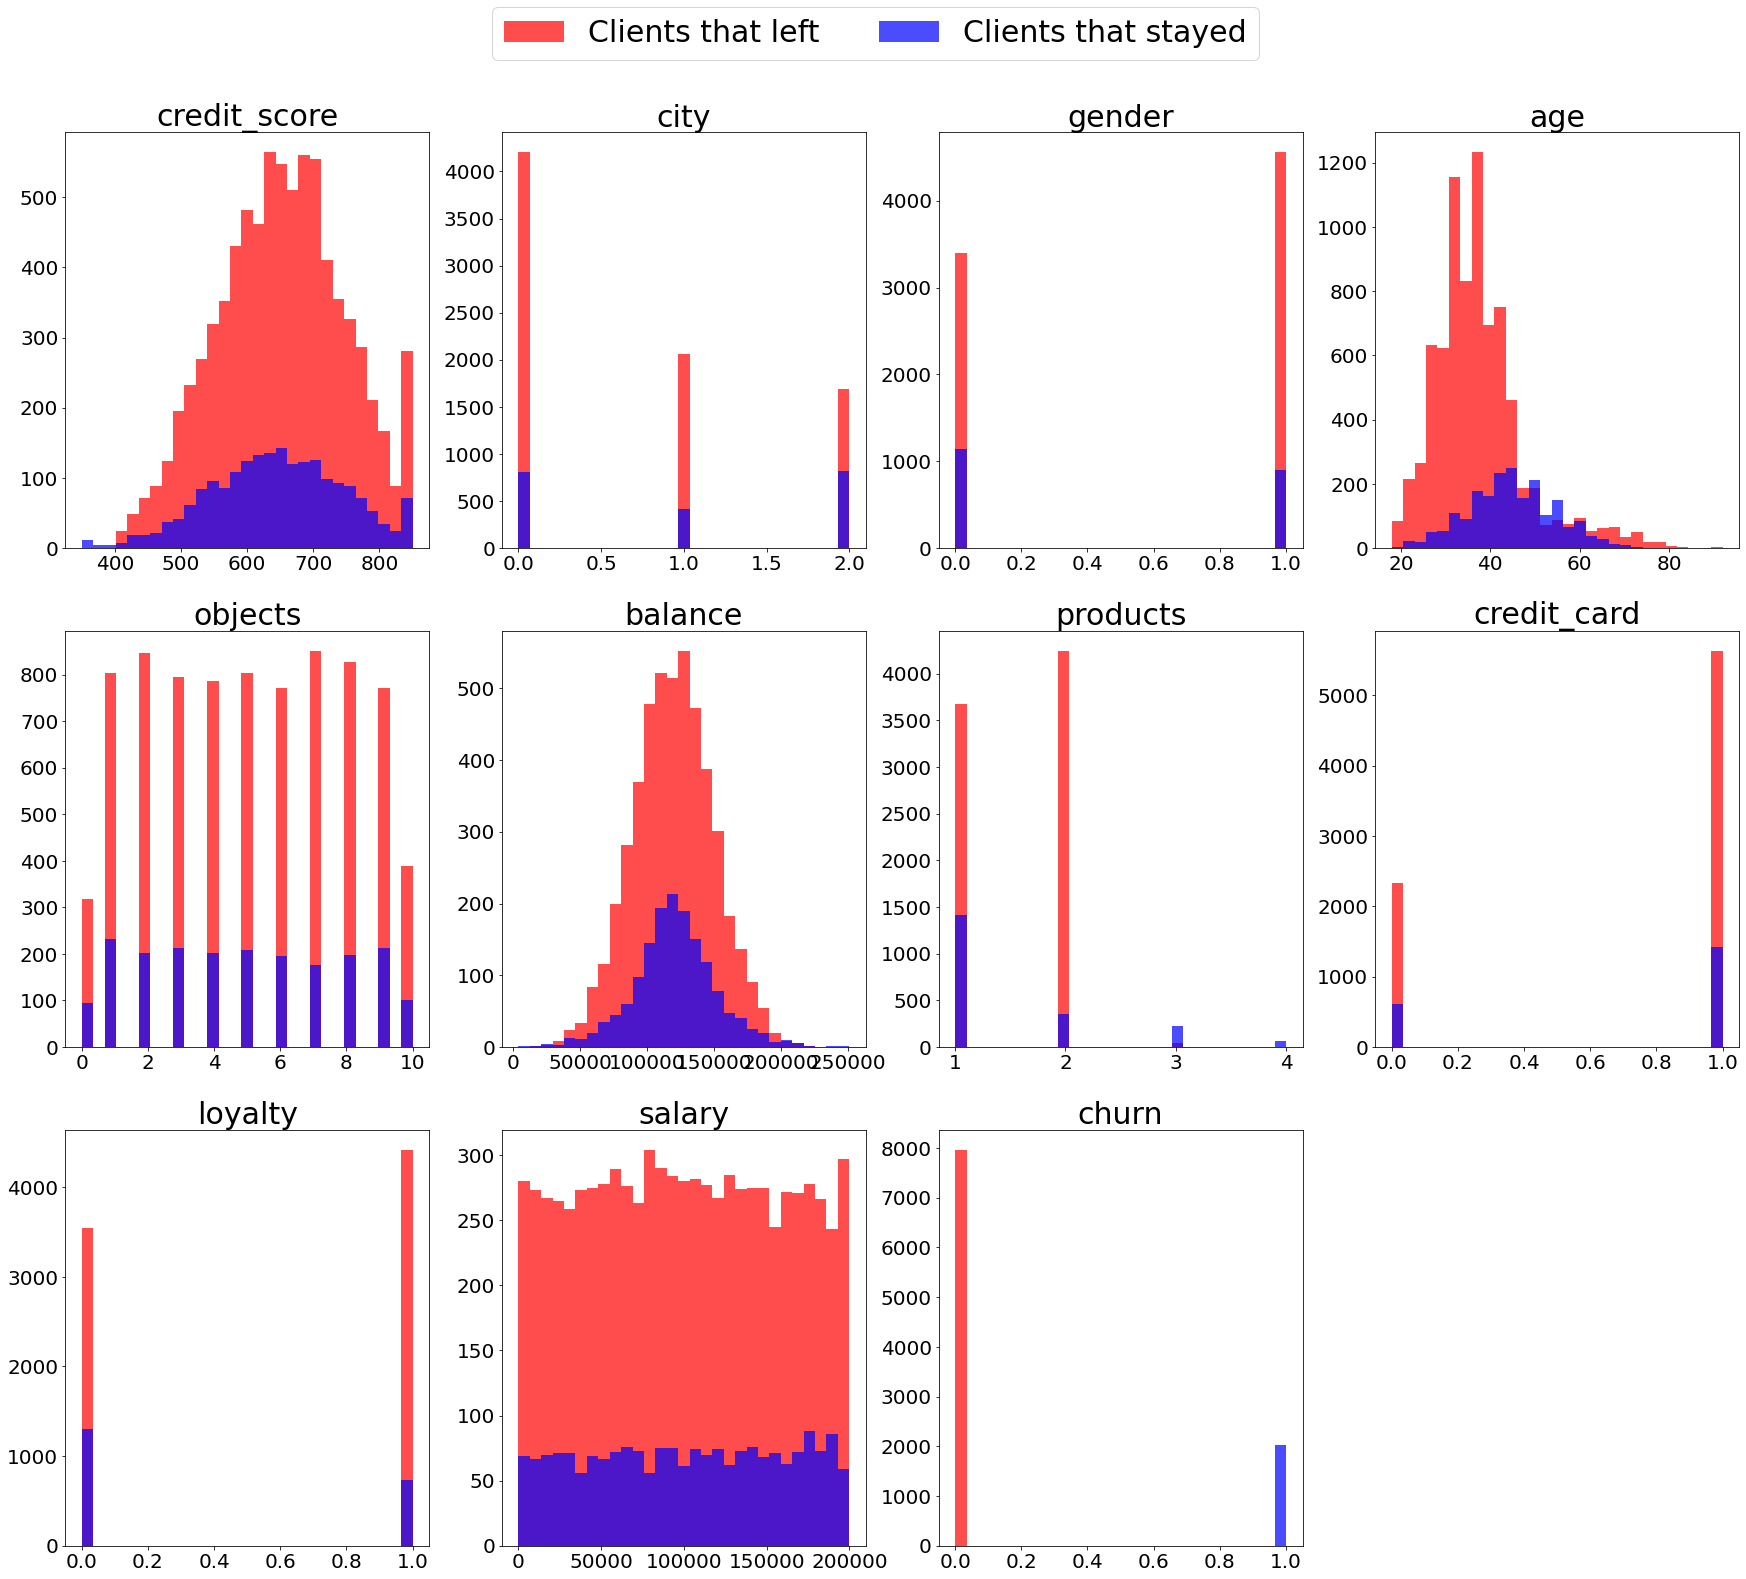

In [19]:
churn_0 = df[df['churn']==0]
churn_1 = df[df['churn']==1]

plot_columns = 4
plot_rows = 3

n_bins = 30

fig, ax = plt.subplots(plot_rows, plot_columns, figsize=(30, 26))

ax = ax.flatten()

labels=['Clients that left', 'Clients that stayed']

for i in range(len(df.columns)):
    
    col = df.columns[i]
    
    bins = np.linspace(df[col].min(), df[col].max(), n_bins)
    
    ax[i].hist(churn_0[col], bins, alpha=.7, color='red')
    ax[i].hist(churn_1[col], bins, alpha=.7, color='blue')
    ax[i].set_title(df.columns[i], fontsize=30)
    ax[i].tick_params(axis='both', labelsize=20)


fig.delaxes(ax[11])

fig.legend(labels, loc=9, prop={'size': 30}, ncol=2, bbox_to_anchor=[0.5, 0.955])

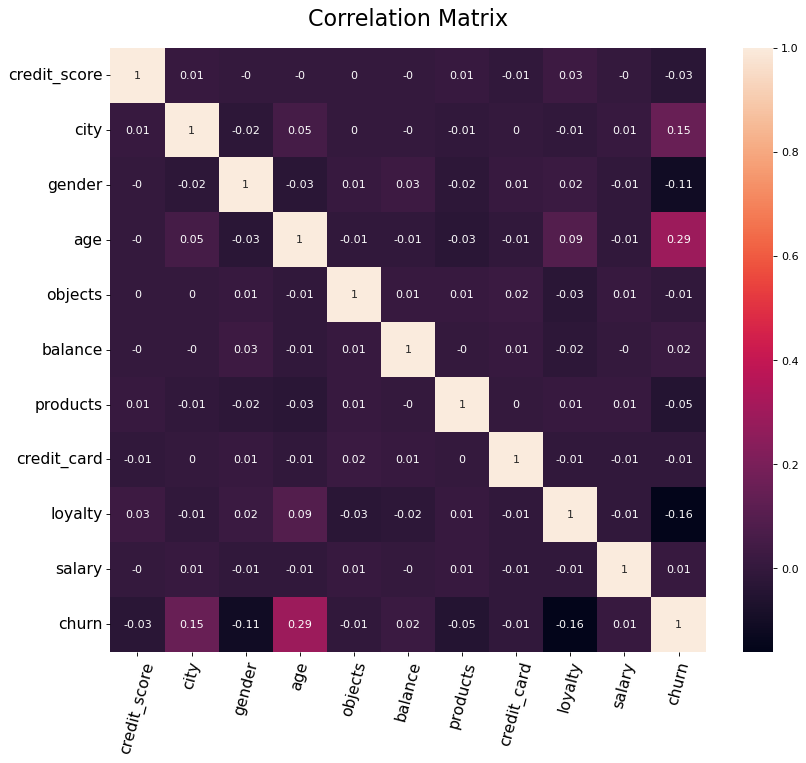

In [20]:
plt.figure(figsize=(12, 10), dpi= 80)
sb.heatmap(df.corr().round(2), annot=True)

plt.xticks(fontsize=14, rotation=75)
plt.yticks(fontsize=14)

plt.title('Correlation Matrix', fontsize=20, pad=20)

plt.show()

As we can see two features have somewhat strong correlation between them - Gender and Age, therefore we can now suggest that mostly elder clients with certain gender have tendency to leave.

In [21]:
X = df.drop(['products', 'balance'], axis=1)
y = df['products']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

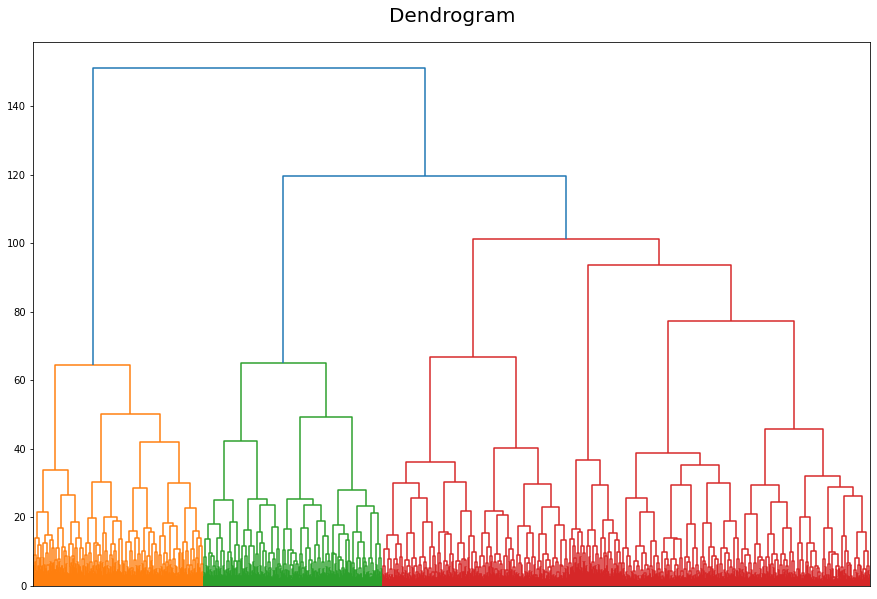

In [24]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Dendrogram', fontsize=20, pad=20)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.show()

With Dendrigram showing us 3 clusters, lets use K-means to examing them

In [25]:
km = KMeans(n_clusters=3, random_state=0)

labels = km.fit_predict(X_sc)

df['cluster_km'] = labels

df.groupby('cluster_km').mean().round(2)

,credit_score,city,gender,age,objects,balance,products,credit_card,loyalty,salary,churn
cluster_km,,,,,,,,,,,
0,645.45,1.00,0.44,44.87,4.94,120739.61,1.47,0.70,0.36,101471.15,1.0
1,648.86,0.67,0.57,35.45,5.13,120380.48,1.56,0.71,0.00,100338.85,0.0
2,654.21,0.70,0.58,38.96,4.96,118881.25,1.54,0.71,1.00,99253.06,0.0


From all three groups, first one (under '0' index) is of particular interest. It has Churn value of 1, gender mostly female (closer to 0 is female and closer to 1 is male) and age is at mostly 45.

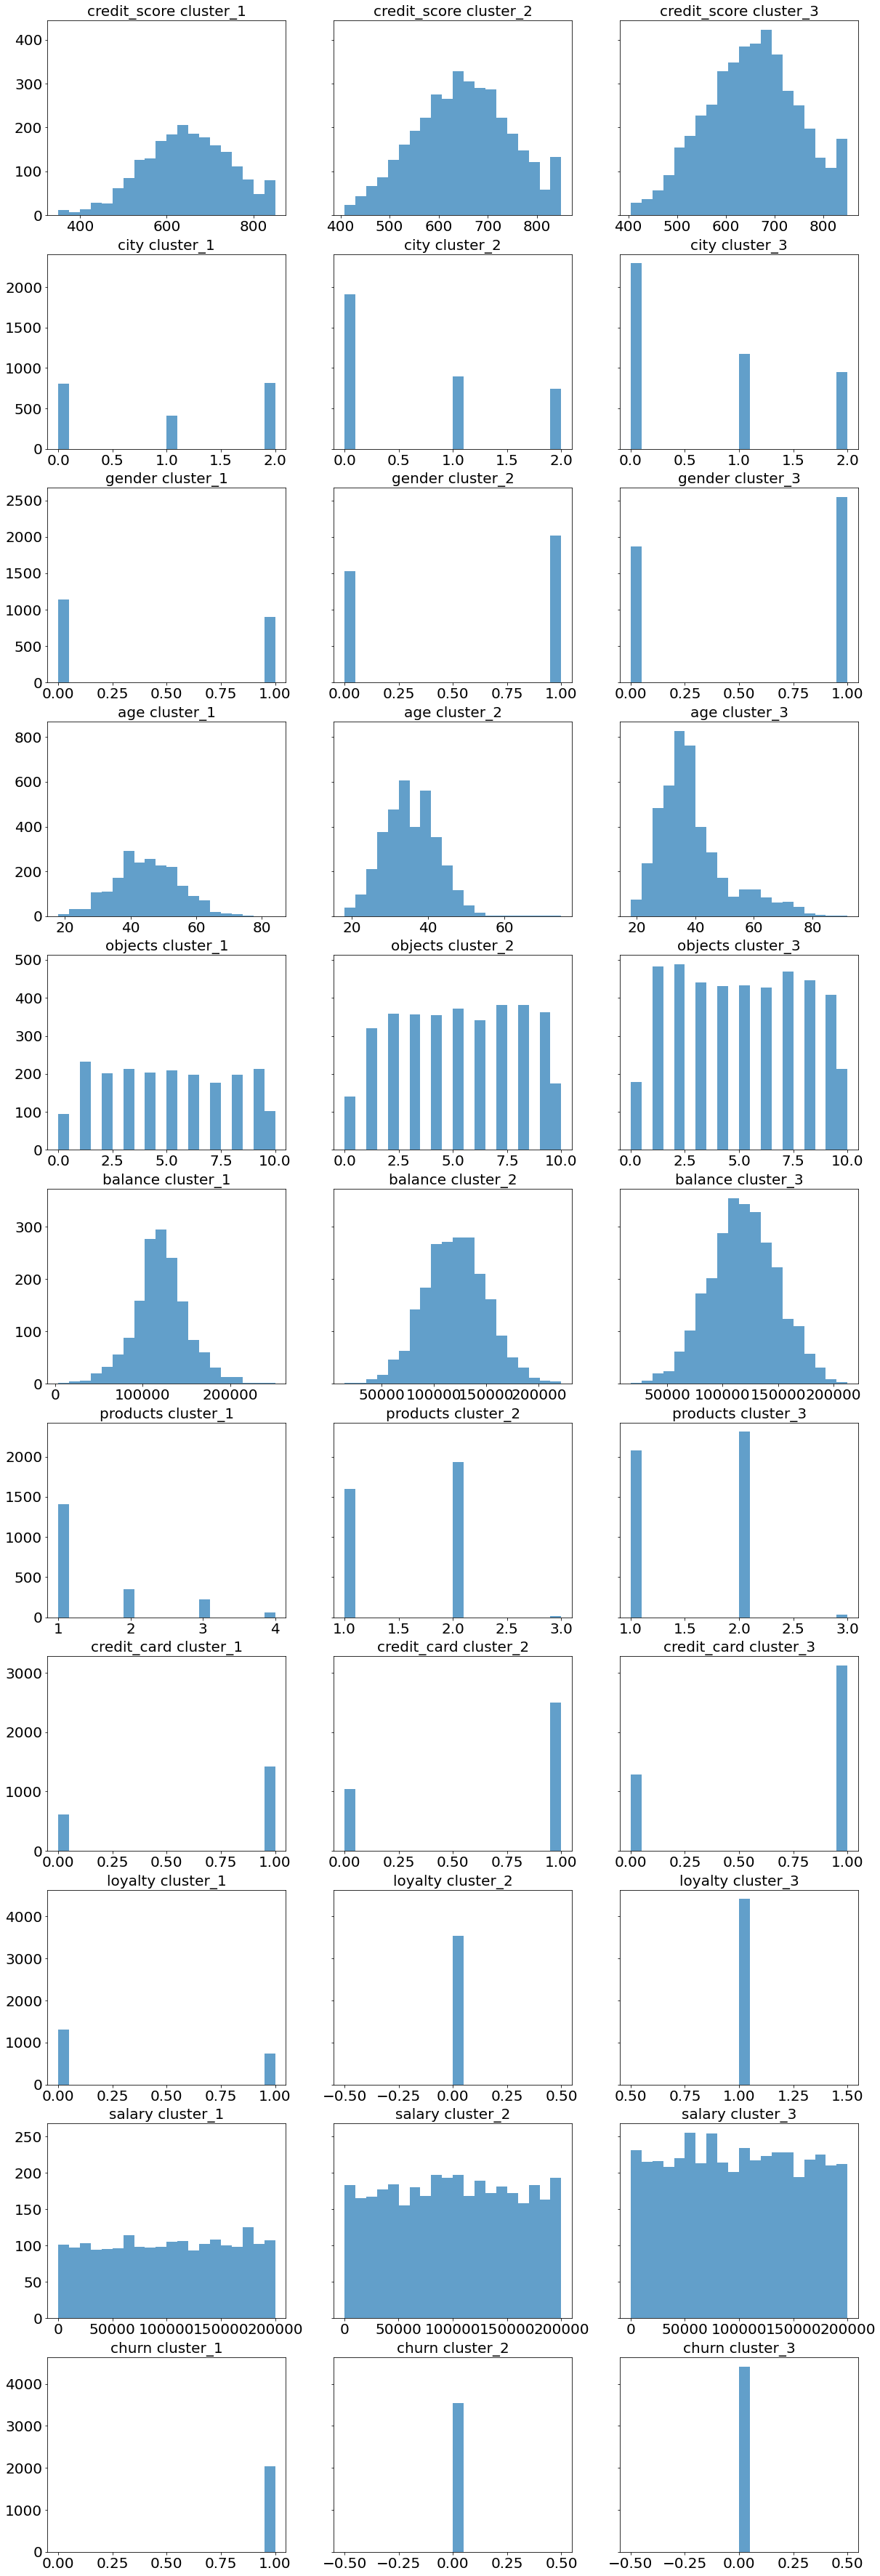

In [26]:
clusters = df.groupby(by=['cluster_km'])

clust_columns = 3

clust_rows = len(df.columns)

clust_bins = 20

fig, ax = plt.subplots(clust_rows, clust_columns, sharey='row', figsize=(20, 70))

for i in range(len(df.columns)):
    for j in range(df['cluster_km'].nunique()):
    
        col = df.columns[i]
    
        bins = np.linspace(df[col].min(), df[col].max(), clust_bins)
    
        ax[i][j].hist(df[df['cluster_km']==j][col], clust_bins, alpha=.7)
        ax[i][j].set_title(df.columns[i] + ' cluster_' + str(j+1), fontsize=20)
        ax[i][j].tick_params(axis='both', labelsize=20)
        
fig.delaxes(ax[11][0])
fig.delaxes(ax[11][1])
fig.delaxes(ax[11][2])
        
plt.show()

Histogramms show us 2 main segments:

1. Female clients ag age 40+ with salary 100.000+ and with more than 3 products
2. Male clients from Yaroslavl under 50 with no more then 2 products

1st group has high churn value, while 2nd group is not that subjected to be leaving bank.

Here we can also determine 3 main client signs for Churn feature: Gender, Age and Number of used products

Lets test some hypotheses

In [27]:
plt.rcParams['figure.figsize'] = [10, 6]

In [28]:
prod_1 = df[df['products'] == 1]
prod_2 = df[df['products'] == 2]

H0: clients with 1 product mean salary = mean salary of clients with 2 products

H1: clients with 1 product mean salary != mean salary of clients with 2 products

In [29]:
alpha = .05

results = st.ttest_ind(prod_1['salary'], prod_2['salary'])

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Abandon H0 hypothesis')
else:
    print('Do not abandon H0 hypothesis')

P-value: 0.41047183624949335
Do not abandon H0 hypothesis


Null hypothesis was not abandoned, therefore salaries of those two groups likely to be very similar

Lets look at this on the graph

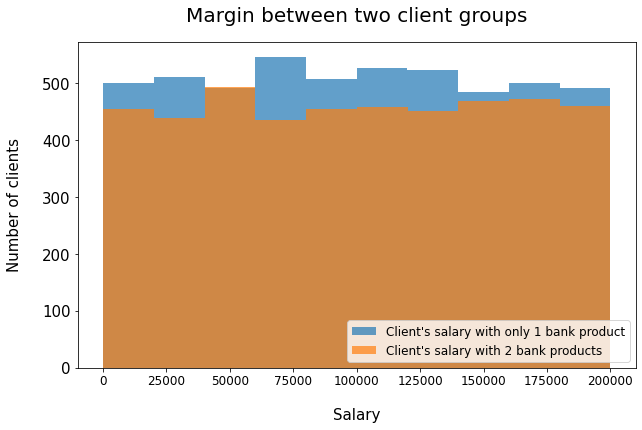

In [30]:
plt.hist(prod_1['salary'], alpha = .7, label = "Client's salary with only 1 bank product")
plt.hist(prod_2['salary'], alpha = .7, label = "Client's salary with 2 bank products")

plt.title('Margin between two client groups', fontsize=20, pad=20)

plt.xlabel('Salary', fontsize=15, labelpad=20)
plt.xticks(size=12)

plt.ylabel('Number of clients', fontsize=15, labelpad=20)
plt.yticks(size=15)

plt.legend(loc='lower right', prop={'size': 12})

plt.show()

In [31]:
df.pivot_table(index='products', columns='churn', values='salary').round().iloc[0:2]

churn,0,1
products,,
1,99045.0,100640.0
2,100417.0,100883.0


That pivot table shows us that there are differences between mean salaries but they are insignificant

H0: Mean salary clients from Yaroslavl = mean salary clients from other cities

H1: Mean salary clients from Yaroslavl != mean salary clients from other cities

In [32]:
main_city = df[df['city'] == 0]
region_cities = df[df['city'] != 0]

In [33]:
alpha = .05

results = st.ttest_ind(main_city['salary'], region_cities['salary'])

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Abandon H0 hypothesis')
else:
    print('Do not abandon H0 hypothesis')

P-value: 0.7390410907921137
Do not abandon H0 hypothesis


Our P-value is very close to '1' which means that mean salary of those two groupd very likely to not have any major diffirences

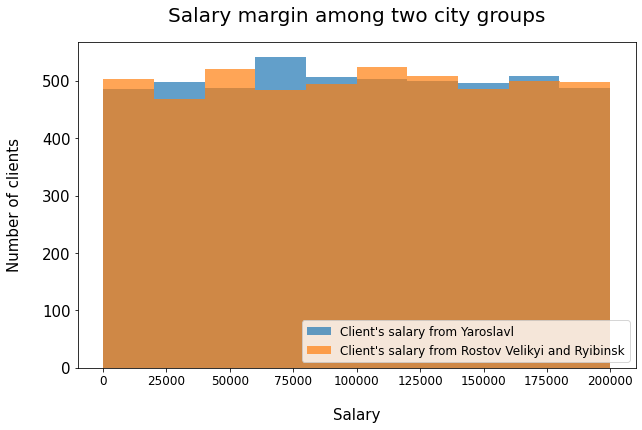

In [34]:
plt.hist(main_city['salary'], alpha = .7, label = "Client's salary from Yaroslavl")
plt.hist(region_cities['salary'], alpha = .7, label = "Client's salary from Rostov Velikyi and Ryibinsk")

plt.title('Salary margin among two city groups', fontsize=20, pad=20)

plt.xlabel('Salary', fontsize=15, labelpad=20)
plt.xticks(size=12)

plt.ylabel('Number of clients', fontsize=15, labelpad=20)
plt.yticks(size=15)

plt.legend(loc='lower right', prop={'size': 12})

plt.show()

H0: Mean churn value of clients over age of 35 = mean churn value of clients under age of 35

H1: Mean churn value of clients over age of 35 != mean churn value of clients under age of 35

In [35]:
age_35_more = df[df['age'] >= 35]['churn']
age_35_less = df[df['age'] < 35]['churn']

In [36]:
alpha = .05

results = st.ttest_ind(age_35_more, age_35_less)

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Abandon H0 hypothesis')
else:
    print('Do not abandon H0 hypothesis')

P-value: 3.3178297623016093e-127
Abandon H0 hypothesis


Well just as we expected mean churn value of those two groupd is different. lets see if its higher or lower

H0: Mean churn value of clients over age of 35 = mean churn value of clients under age of 35

H1: Mean churn value of clients over age of 35 > mean churn value of clients under age of 35

In [37]:
alpha = .05

results = st.ttest_ind(age_35_less, age_35_more)

print('P-value:', results.pvalue / 2)

if (results.pvalue / 2) < alpha and (age_35_more.mean() > age_35_less.mean()):
    print('Abandon H0 hypothesis')
else:
    print('Do not abandon H0 hypothesis')

P-value: 1.6589148811508047e-127
Abandon H0 hypothesis


Conclusion: mean churn value of clients over 35 years is higher then of those under 35 years

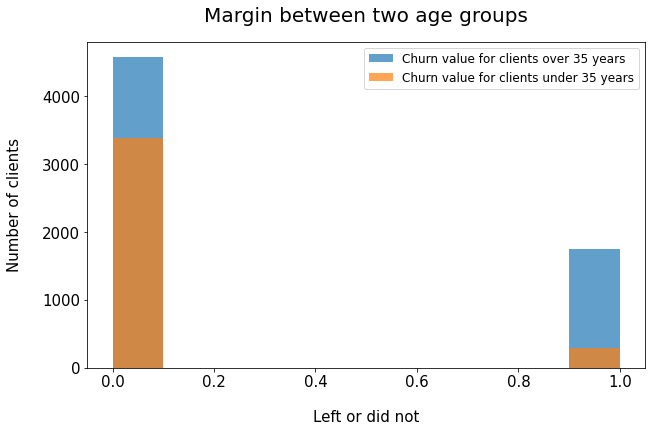

In [38]:
plt.hist(age_35_more, alpha = .7, label = "Churn value for clients over 35 years")
plt.hist(age_35_less, alpha = .7, label = "Churn value for clients under 35 years")

plt.title('Margin between two age groups', fontsize=20, pad=20)

plt.xlabel('Left or did not', fontsize=15, labelpad=20)
plt.xticks(size=15)

plt.ylabel('Number of clients', fontsize=15, labelpad=20)
plt.yticks(size=15)

plt.legend(loc='upper right', prop={'size': 12})

plt.show()

Lets compare clients with different gender

In [39]:
df['gender'].replace([0, 1], ['Male', 'Female'], inplace=True)

In [40]:
df.pivot_table(index='products', columns='gender', values='churn').round(2)

gender,Female,Male
products,,
1,0.23,0.33
2,0.05,0.10
3,0.78,0.87
4,1.00,1.00


In [41]:
df[df['age'].between(40, 50)].pivot_table(index='products', columns='age', values='churn').round(2)

age,40,41,42,43,44,45,46,47,48,49,50
products,,,,,,,,,,,
1,0.28,0.22,0.35,0.39,0.38,0.47,0.54,0.55,0.59,0.59,0.67
2,0.08,0.06,0.08,0.12,0.12,0.14,0.11,0.22,0.23,0.24,0.19
3,0.70,0.76,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [42]:
df[df['age'].between(40, 45)].pivot_table(index='products', columns=['age', 'gender'], values='churn').round(2)

age          40           41           42           43           44        \
gender   Female  Male Female  Male Female  Male Female  Male Female  Male   
products                                                                    
1          0.21  0.34   0.22  0.22   0.30  0.43   0.38  0.40   0.33  0.44   
2          0.06  0.09   0.01  0.13   0.06  0.09   0.14  0.11   0.07  0.19   
3          0.86  0.33   0.75  0.78   0.60  0.89   1.00  1.00   1.00  1.00   
4          1.00  1.00   1.00  1.00    NaN  1.00   1.00  1.00   1.00   NaN   

age          45        
gender   Female  Male  
products               
1          0.34  0.60  
2          0.14  0.14  
3          1.00  1.00  
4          1.00  1.00

In [43]:
(
    df[df['age'].between(40, 45)]
    .pivot_table(index='products', columns=['age', 'gender'], values='churn')
    .describe()
    .round(2)
).loc['mean']

age  gender
40   Female    0.53
     Male      0.44
41   Female    0.50
     Male      0.53
42   Female    0.32
     Male      0.60
43   Female    0.63
     Male      0.63
44   Female    0.60
     Male      0.54
45   Female    0.62
     Male      0.69
Name: mean, dtype: float64

Conclusion

After clasterization and examination of our data we can make our two distinctive groups:

- Female clients over 40 years old with salary over 100.000 and with 3 or more bank products
- Male clients under 40 years old with no more then 2 bank products.

First group is more susceptible to leave bank as the time goes and latter is less susceptible to it.